## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
    #print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


In [ ]:
print(train_loader)

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 500),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.Tanh(),
            nn.Linear(200, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
            Linear-4                  [-1, 200]         100,200
              Tanh-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
        LogSoftmax-7                   [-1, 10]               0
Total params: 494,710
Trainable params: 494,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.89
Estimated Total Size (MB): 1.91
----------------------------------------------------------------


Your experiments come here:

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
n_epoch = 10
for epoch in range(n_epoch):
  train_loss_loop = []
  test_loss_loop = []
  train_accuracy_loop = []
  test_accuracy_loop = []
  model.train(True)
  for X_batch, y_batch in train_loader:
    pred = model(X_batch.to(device))
    loss = loss_func(pred, y_batch.to(device))
    loss.backward()
    opt.step()
    opt.zero_grad()
    train_loss_loop.append(loss.item())
    train_accuracy_loop.append((pred.max(1)[1].data == y_batch.to(device)).to(torch.float32).mean().item())

  model.train(False)
  with torch.no_grad():
    for X_batch, y_batch in test_loader:
      pred = model(X_batch.to(device))
      test_loss_loop.append(loss_func(pred, y_batch.to(device)).item())
      test_accuracy_loop.append((pred.max(1)[1].data == y_batch.to(device)).to(torch.float32).mean().item())

  train_loss.append(np.mean(train_loss_loop))
  test_loss.append(np.mean(test_loss_loop))
  train_accuracy.append(np.mean(train_accuracy_loop))
  test_accuracy.append(np.mean(test_accuracy_loop))


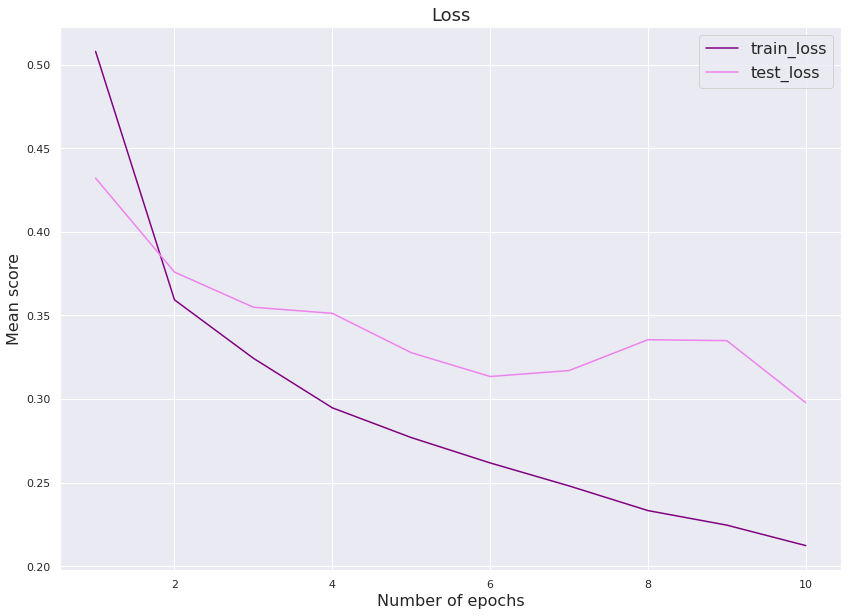

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")

plt.figure(figsize=(14, 10))
plt.title('Loss', fontsize=18)
plt.xlabel('Number of epochs', fontsize=16)
plt.ylabel('Mean score', fontsize=16)
N = np.arange(n_epoch) + 1
plt.plot(N, train_loss, label='train_loss', color='purple')
plt.plot(N, test_loss, label='test_loss', color='violet')
plt.legend(fontsize=16)
plt.show()

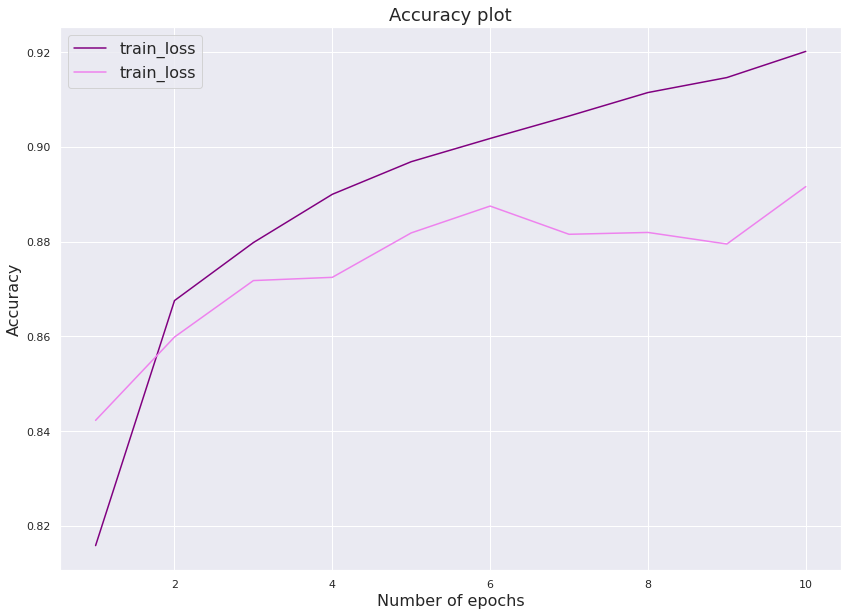

In [ ]:
plt.figure(figsize=(14, 10))
plt.title('Accuracy plot', fontsize=18)
plt.xlabel('Number of epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
N = np.arange(n_epoch) + 1
plt.plot(N, train_accuracy, label='train_loss', color='purple')
plt.plot(N, test_accuracy, label='train_loss', color='violet')

plt.legend(fontsize=16)
plt.show()

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfitingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 2000),
            nn.ReLU(),
            nn.Linear(2000, 1000),
            nn.Tanh(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
            Linear-4                  [-1, 200]         100,200
              Tanh-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
        LogSoftmax-7                   [-1, 10]               0
Total params: 494,710
Trainable params: 494,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.89
Estimated Total Size (MB): 1.91
----------------------------------------------------------------


In [ ]:
subind = np.random.choice(np.arange(len(fmnist_dataset_train)), len(fmnist_dataset_train) // 10, replace=False)

train_subset = torch.utils.data.Subset(fmnist_dataset_train, subind)
train_subset_loader = torch.utils.data.DataLoader(train_subset, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

In [ ]:
model = OverfitingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
n_epoch = 30
for epoch in range(n_epoch):
  train_loss_loop = []
  test_loss_loop = []
  train_accuracy_loop = []
  test_accuracy_loop = []
  model.train(True)
  for X_batch, y_batch in train_subset_loader:
    pred = model(X_batch.to(device))
    loss = loss_func(pred, y_batch.to(device))
    loss.backward()
    opt.step()
    opt.zero_grad()
    train_loss_loop.append(loss.item())
    train_accuracy_loop.append((pred.max(1)[1].data == y_batch.to(device)).to(torch.float32).mean().item())

  model.train(False)
  with torch.no_grad():
    for X_batch, y_batch in test_loader:
      pred = model(X_batch.to(device))
      test_loss_loop.append(loss_func(pred, y_batch.to(device)).item())
      test_accuracy_loop.append((pred.max(1)[1].data == y_batch.to(device)).to(torch.float32).mean().item())

  train_loss.append(np.mean(train_loss_loop))
  test_loss.append(np.mean(test_loss_loop))
  train_accuracy.append(np.mean(train_accuracy_loop))
  test_accuracy.append(np.mean(test_accuracy_loop))


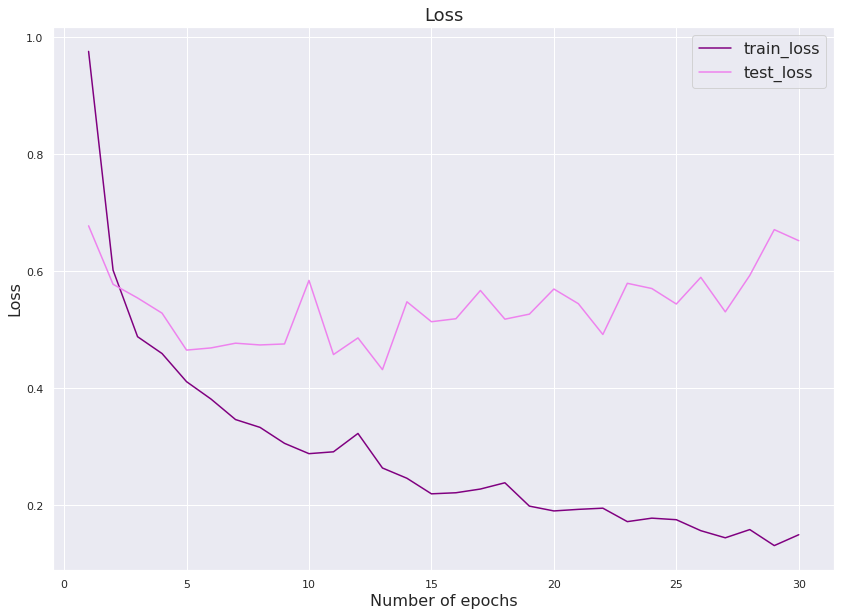

In [ ]:
plt.figure(figsize=(14, 10))
plt.title('Loss', fontsize=18)
plt.xlabel('Number of epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
N = np.arange(n_epoch) + 1
plt.plot(N, train_loss, label='train_loss', color='purple')
plt.plot(N, test_loss, label='test_loss', color='violet')
plt.legend(fontsize=16)
plt.show()

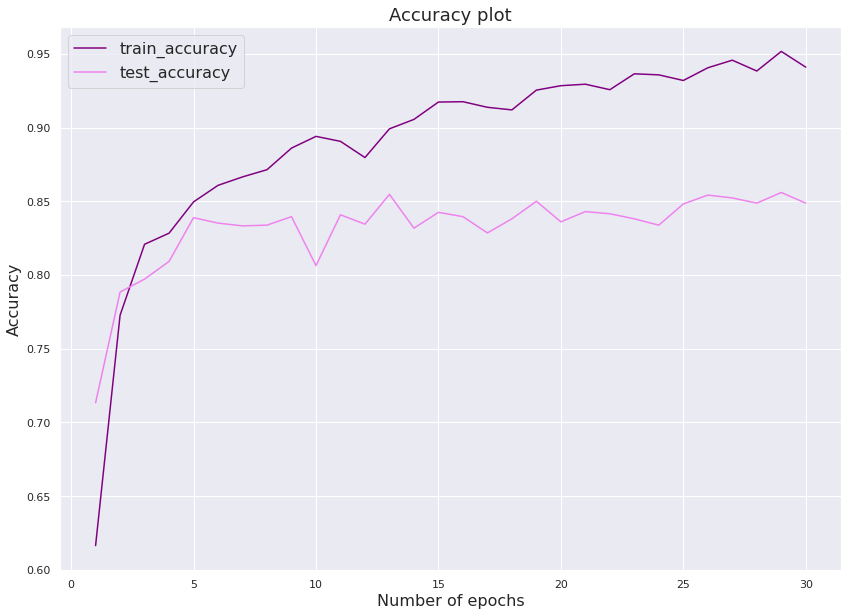

In [ ]:
plt.figure(figsize=(14, 10))
plt.title('Accuracy plot', fontsize=18)
plt.xlabel('Number of epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
N = np.arange(n_epoch) + 1
plt.plot(N, train_accuracy, label='train_accuracy', color='purple')
plt.plot(N, test_accuracy, label='test_accuracy', color='violet')

plt.legend(fontsize=16)
plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Dropout(p=0.7),
            nn.Linear(input_shape, 2000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2000, 1000),
            nn.Tanh(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                 [-1, 2000]       1,570,000
              ReLU-4                 [-1, 2000]               0
           Dropout-5                 [-1, 2000]               0
            Linear-6                 [-1, 1000]       2,001,000
              Tanh-7                 [-1, 1000]               0
            Linear-8                  [-1, 500]         500,500
              ReLU-9                  [-1, 500]               0
          Dropout-10                  [-1, 500]               0
           Linear-11                  [-1, 250]         125,250
             ReLU-12                  [-1, 250]               0
           Linear-13                   [-1, 10]           2,510
       LogSoftmax-14                   

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
n_epoch = 30
for epoch in range(n_epoch):
  train_loss_loop = []
  test_loss_loop = []
  train_accuracy_loop = []
  test_accuracy_loop = []
  model.train(True)
  for X_batch, y_batch in train_subset_loader:
    pred = model(X_batch.to(device))
    loss = loss_func(pred, y_batch.to(device))
    loss.backward()
    opt.step()
    opt.zero_grad()
    train_loss_loop.append(loss.item())
    train_accuracy_loop.append((pred.max(1)[1].data == y_batch.to(device)).to(torch.float32).mean().item())

  model.train(False)
  with torch.no_grad():
    for X_batch, y_batch in test_loader:
      pred = model(X_batch.to(device))
      test_loss_loop.append(loss_func(pred, y_batch.to(device)).item())
      test_accuracy_loop.append((pred.max(1)[1].data == y_batch.to(device)).to(torch.float32).mean().item())

  train_loss.append(np.mean(train_loss_loop))
  test_loss.append(np.mean(test_loss_loop))
  train_accuracy.append(np.mean(train_accuracy_loop))
  test_accuracy.append(np.mean(test_accuracy_loop))
  print("{}/30 epoch, train_loss: {}, test_loss: {}, accuracy: {}".format(epoch, train_loss[epoch], test_loss[epoch], test_accuracy[epoch]))


0/30 epoch, train_loss: 1.2959141997580832, test_loss: 0.7870730094611644, accuracy: 0.68876953125
1/30 epoch, train_loss: 0.8475684802582923, test_loss: 0.6902697026729584, accuracy: 0.72763671875
2/30 epoch, train_loss: 0.768123133385435, test_loss: 0.651802460104227, accuracy: 0.75322265625
3/30 epoch, train_loss: 0.7370001572243711, test_loss: 0.6858807809650898, accuracy: 0.7337890625
4/30 epoch, train_loss: 0.7000684788886536, test_loss: 0.616868057847023, accuracy: 0.7611328125
5/30 epoch, train_loss: 0.6808991305371548, test_loss: 0.6244239144027233, accuracy: 0.75322265625
6/30 epoch, train_loss: 0.673231674001572, test_loss: 0.6574031472206116, accuracy: 0.73671875
7/30 epoch, train_loss: 0.6657717018685443, test_loss: 0.5978585340082645, accuracy: 0.762890625
8/30 epoch, train_loss: 0.6434993173213716, test_loss: 0.566291055828333, accuracy: 0.7822265625
9/30 epoch, train_loss: 0.6347054636224787, test_loss: 0.577622102946043, accuracy: 0.7841796875
10/30 epoch, train_loss: 

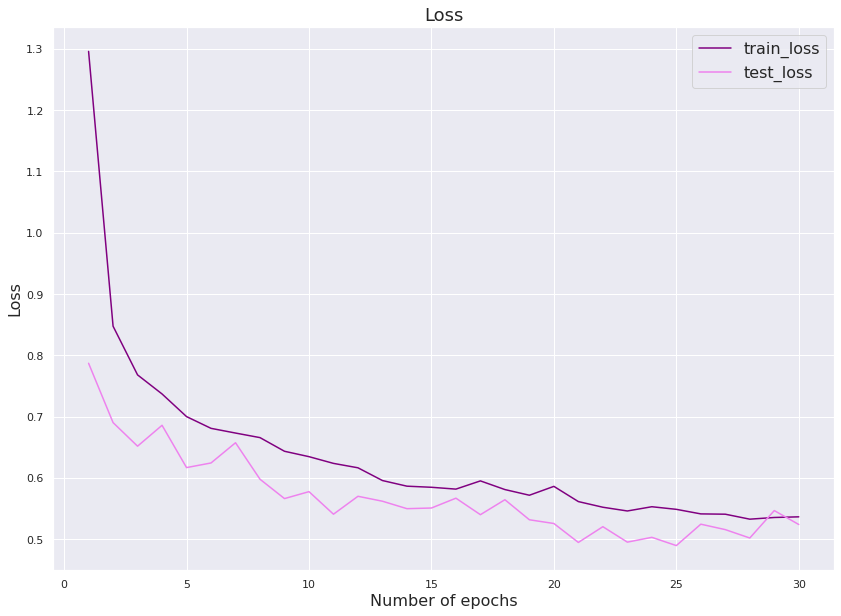

In [ ]:
plt.figure(figsize=(14, 10))
plt.title('Loss', fontsize=18)
plt.xlabel('Number of epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
N = np.arange(n_epoch) + 1
plt.plot(N, train_loss, label='train_loss', color='purple')
plt.plot(N, test_loss, label='test_loss', color='violet')
plt.legend(fontsize=16)
plt.show()

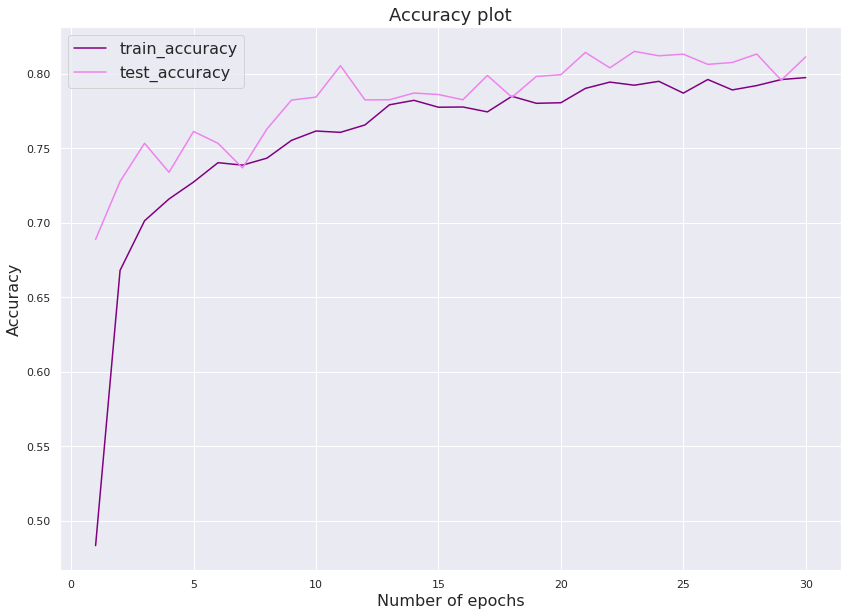

In [ ]:
plt.figure(figsize=(14, 10))
plt.title('Accuracy plot', fontsize=18)
plt.xlabel('Number of epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
N = np.arange(n_epoch) + 1
plt.plot(N, train_accuracy, label='train_accuracy', color='purple')
plt.plot(N, test_accuracy, label='test_accuracy', color='violet')

plt.legend(fontsize=16)
plt.show()

### Conclusions:
_Write down small report with your conclusions and your ideas._

First of all, there was accuracy about 0.92, which is very good. Overfitting - when train_loss decresing and test_loss increscing. This was visiable on the plot for task2. Dropout and normalization helped with overfitting problem, but accuracy now is only about 0.8, which is understandable, because we left only 0.1 of the dataset.